In [1]:
import psycopg2
import numpy as np
from pandas.io.sql import read_sql
%matplotlib inline
import matplotlib.pyplot as plt

In [29]:
pgconn = psycopg2.connect(database='sustainablecorn', host='iemdb', user='nobody')
df = read_sql("""
    with obs as (
        SELECT o.valid, extract(hour from o.valid) as hr,
        o.plotid, o.discharge_mm as discharge_mm,
        lag(o.discharge_mm) OVER (PARTITION by o.plotid ORDER by o.valid ASC) as discharge_mm_lag,
        t.depth_mm as depth_mm, lag(t.depth_mm) OVER (PARTITION by o.plotid ORDER by o.valid ASC)
        as depth_mm_lag from tileflow_data o JOIN watertable_data t
        on (date_trunc('minute', o.valid) = date_trunc('minute', t.valid)
            and  t.plotid = o.plotid ) WHERE o.uniqueid = 'STJOHNS' and
        discharge_mm is not null and depth_mm is not null),
    agg as (
        SELECT min(valid) as v, plotid, hr::int % 4 as hrr,
        sum(discharge_mm) as sum_discharge, avg(depth_mm) as avg_depth from obs
        GROUP by date(valid), plotid, hrr
    )
    SELECT v, plotid, sum_discharge, avg_depth,
    lag(sum_discharge) OVER (PARTITION by plotid ORDER by v ASC) as sum_discharge_lag ,
    lag(avg_depth) OVER (PARTITION by plotid ORDER by v ASC) as avg_depth_lag from agg

""", pgconn)
print len(df.index)

9832


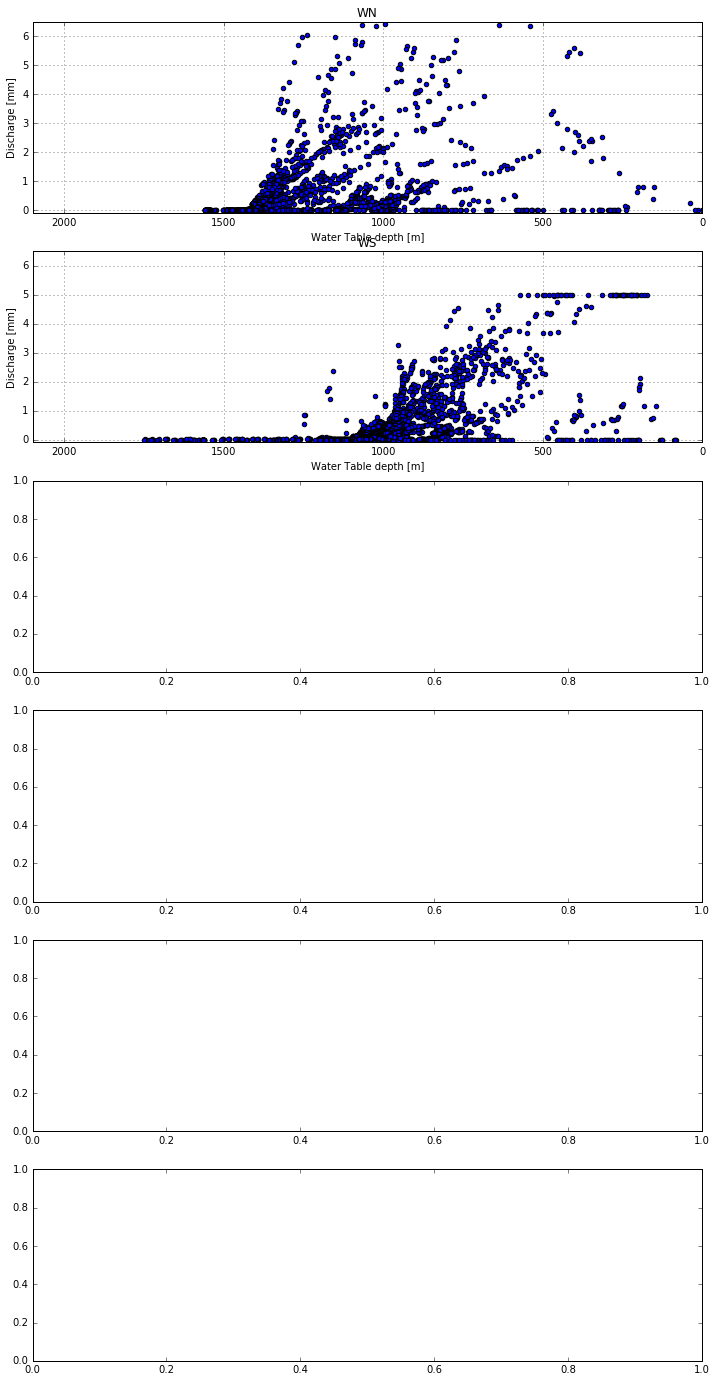

In [35]:
(fig, ax) = plt.subplots(6, 1, figsize=(12, 24))

plots = df['plotid'].unique()
plots.sort()
for i, plotid in enumerate(plots):
    df2 = df[(df['plotid']==plotid)]
    ax[i].scatter( df2['avg_depth'], df2['sum_discharge'])
    ax[i].set_ylabel("Discharge [mm]")
    ax[i].grid(True)
    ax[i].set_ylim(-0.1, 6.5)
    ax[i].set_xlim(2100, 0)
    ax[i].set_title(plotid)
    ax[i].set_xlabel("Water Table depth [m]")

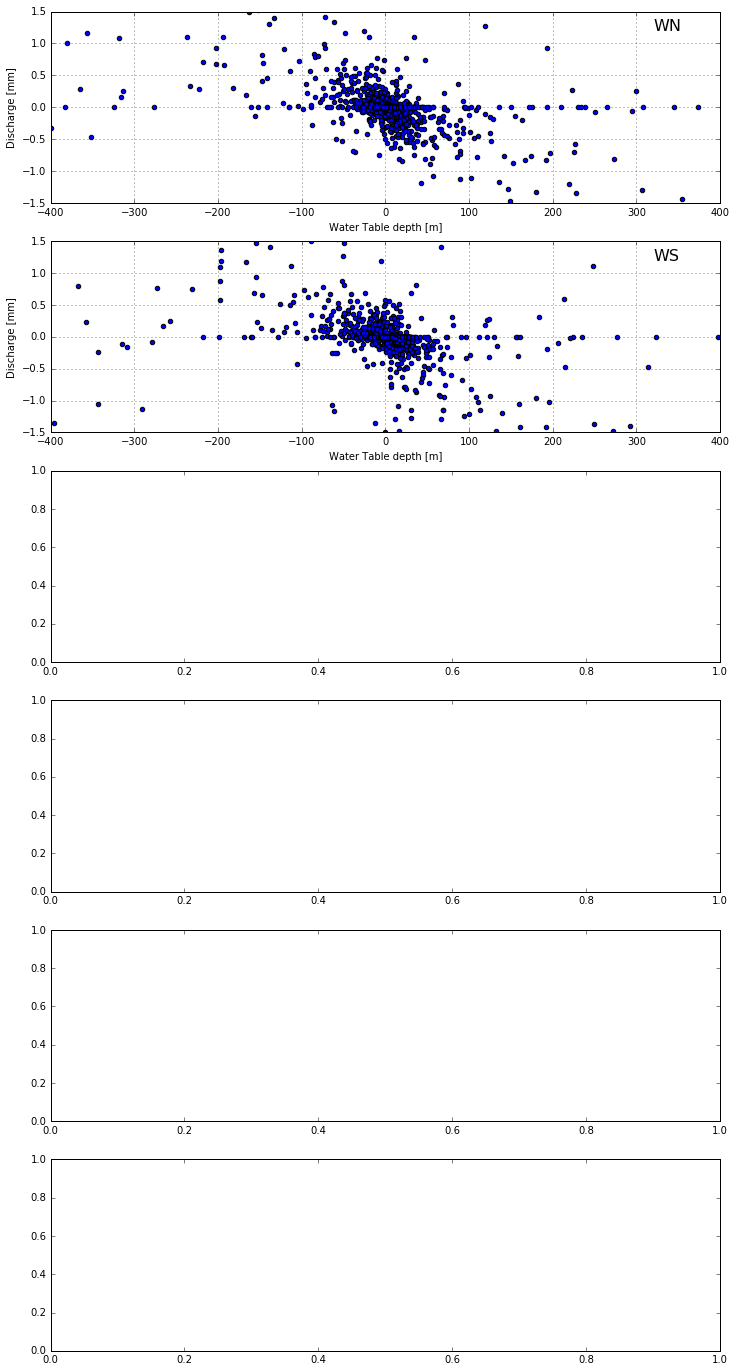

In [31]:
(fig, ax) = plt.subplots(6, 1, figsize=(12, 24))

plots = df['plotid'].unique()
plots.sort()
for i, plotid in enumerate(plots):
    df2 = df[(df['plotid']==plotid)]
    ax[i].scatter( df2['avg_depth'] - df2['avg_depth_lag'],
                  df2['sum_discharge'] - df2['sum_discharge_lag'])
    ax[i].set_ylabel("Discharge [mm]")
    ax[i].grid(True)
    ax[i].set_ylim(-1.5, 1.5)
    ax[i].set_xlim(-400, 400)
    ax[i].text(0.9, 0.9, str(plotid), fontsize=16, transform=ax[i].transAxes)
    #ax[i].set_title(plotid)
    ax[i].set_xlabel("Water Table depth [m]")